<a href="https://colab.research.google.com/github/JulienPeignon/MonteCarlo/blob/main/unbiased_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# **1) GENERATION DES DONNEES**

In [2]:
def generation_z(A,b,K,covar,x):
    z_O = []
    z_E = []
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(np.dot(A,x)+b, (2/3)*covar))
        z_E.append(np.random.multivariate_normal(np.dot(A,x)+b, (2/3)*covar))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [3]:
def generation_q_p(A,b,K,mean_vect,covar,x,z,z_O,z_E):
    q, p, q_O, p_O, q_E, p_E = [],[],[],[],[],[]
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=np.dot(A,x)+b, cov=(2/3)*covar))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=np.dot(A,x)+b, cov=(2/3)*covar))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean_vect, cov=covar)*multivariate_normal.pdf(x, mean=z_O[i], cov=covar))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean_vect, cov=covar)*multivariate_normal.pdf(x, mean=z_E[i], cov=covar))
    q,p = q_O.copy(),p_O.copy()
    q.extend(q_E)
    p.extend(p_E)
    return q, p, q_O, p_O, q_E, p_E

# **2) FONCTION POUR SS**

In [4]:
def estimator_ML_SS(n_sim, x, mean_vect, covar, A, b, r):

    ss = []
    for i in range(n_sim):

        # generate our data following our true parameter theta_true and our observations at mean_vect
        K = np.random.geometric(r)

        z, z_O, z_E = generation_z(A,b,K,covar,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K,mean_vect,covar,x,z,z_O,z_E)

        # compute the proposal "posterior"
        w = [p[i]/q[i] for i in range(len(p))] 
        w_O = [p_O[i]/q_O[i] for i in range(len(p_O))] 
        w_E = [p_E[i]/q_E[i] for i in range(len(p_E))] 
            
        # compute I0
        I0 = np.mean(np.log(w))

        # compute Lo and Le
        lO = np.log(np.mean(w_O))
        lE = np.log(np.mean(w_E))  

        # compute L_OE
        L_OE = np.log(np.mean(w))
    
        # compute delta_K
        delta_K = L_OE - 0.5*(lO + lE)
    
        # compute the final estimator
        proba = r*(1-r)**(int(K)-1)
        ML_SS = I0 + delta_K/proba
        
        ss.append(ML_SS)

    
    mean_value = np.mean(ss)
    std_error_value = np.std(ss) / np.sqrt(len(ss))

    return mean_value #the mean value of the log likelihood 

#print("Mean: " + str(mean_value) + "\n" + "Standard error: " + str(std_error_value))

In [5]:
def estimate_theta(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [6]:
def calcul_likelihood(x,theta):
  cste = (2*np.pi)**(-len(x)/2)*1/(np.sqrt(np.linalg.det(2*np.identity(20))))
  somme = 0
  for i in range(len(x)):
    somme += (x[i] - theta)**2
  return cste*np.exp(-somme/4)

In [7]:
def gaussian_experience(debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  theta_estimator, X, Y = estimate_theta(x,debut,fin,n_sim,n_interval)
  #print("theta estimé =",theta_estimator)
  plt.scatter(X,Y,color = 'blue',label = 'log-likelihood estimée')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'log-likelihood théorique')
  plt.legend()

  biais_median = np.median([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  biais_mean = np.mean([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  print("le biais squared médian de la log likelihood vaut",biais_median )
  print("le biais squared moyen de la log likelihood vaut",biais_mean )
  #plt.figure(2)
  #mymodel = np.poly1d(np.polyfit(X, Y, 2))
  #myline = np.linspace(debut, fin, n_interval)
  #print("theta estimé par régression quadratique",myline[list(mymodel(myline)).index(max(mymodel(myline)))])
  #plt.scatter(X, Y, color = 'blue',label = 'log-likelihood en fonction de theta')
  #plt.plot(myline, mymodel(myline),color = 'red',label = 'modélisation quadratique de la log-likelihood')
  #plt.legend()
  #plt.show()

  #biais = abs(theta_estimator - theta)
  #return biais

true value of theta 0.8347239491576397
25%
50%
75%
le biais médian de la log likelihood vaut 12.691374636697638
le biais moyen de la log likelihood vaut 17.916021376598035


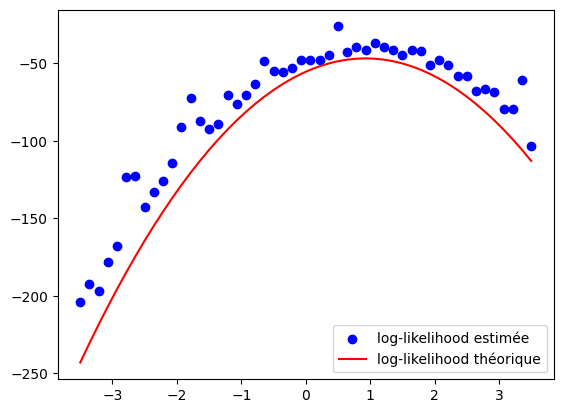

In [ ]:
gaussian_experience()

In [8]:
def estimate_theta_exp(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the likelihood
    Y = [] #values of the likelihoods computed

    for k in liste:
      
            Y.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k, np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the loglikelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

# **3) FONCTION POUR RUSSIAN ROULETTE**

In [9]:
def delta(w, w_O, w_E, K): # le ième élement de delta renvoie la value de delta_i
  delta = []
  sum = 0
  for k in range(int(K)+1):
    wk = w[:2**k]
    wk.extend(w[2**int(K):2**int(K) + 2**k])
    value = np.log(np.mean(wk)) - 0.5*(np.log(np.mean(w_O[:2**k])) + np.log(np.mean(w_E[:2**k])))
    delta.append(value)
  return delta

In [10]:
def estimator_ML_RR(n_sim, x, mean, cov, A, b, r):
    rr = []

    for i in range(n_sim):

        sum_rr = 0

        K = np.random.geometric(r, 1)
        z, z_O, z_E = generation_z(A,b,K,cov,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K,mean,cov,x,z,z_O,z_E)

        w = [p[i]/q[i] for i in range(len(p))] 
        w_O = [p_O[i]/q_O[i] for i in range(len(p_O))] 
        w_E = [p_E[i]/q_E[i] for i in range(len(p_E))]
            
        I0 = np.mean(np.log(w))
        
        # we compute the values of P(K >= k)
        proba_value = [1]
        for i in range(1,int(K)+1):
          proba_value.append((1-r)**(i-1))

        value_somme = [delta(w, w_O, w_E, K)[i]/proba_value[i] for i in range(int(K)+1)]

        sum_rr = sum(value_somme)
            
        ml_ll_rr = I0 + sum_rr
        rr.append(ml_ll_rr)
        
    mean_value = np.mean(rr)
    std_error_value = np.std(rr) / np.sqrt(len(rr))

    return mean_value

    #return print("Mean: " + str(mean_value) + "\n" + "Standard error: " + str(std_error_value))

In [11]:
def estimate_theta_RR(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [12]:
def estimate_both_SS_RR(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')

            c+=1
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    #theta_estimator = X[Y.index(max(Y))]

    
    return X, Y_SS,Y_RR

In [13]:
def gaussian_experience_full(debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR(x,debut,fin,n_sim,n_interval)
  #print("theta estimé =",theta_estimator)
  plt.figure(1)
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimée via SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimée via RR')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'log-likelihood théorique')
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

  #theta_estimator, X_RR, Y_RR = estimate_theta_RR(x,debut,fin,n_sim,n_interval)
  #plt.figure(2)
  #plt.scatter(X_RR,Y_RR,color = 'blue',label = 'log-likelihood estimée via RR')
  #plt.plot(X_RR,Y_theorique, color = 'red',label = 'log-likelihood théorique')
  #plt.legend()

  #biais_median = np.median([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  #biais_mean = np.mean([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  #print("le biais médian de la log likelihood vaut",biais_median )
  #print("le biais moyen de la log likelihood vaut",biais_mean )

true value of theta -0.78852425948745
25%
50%
75%


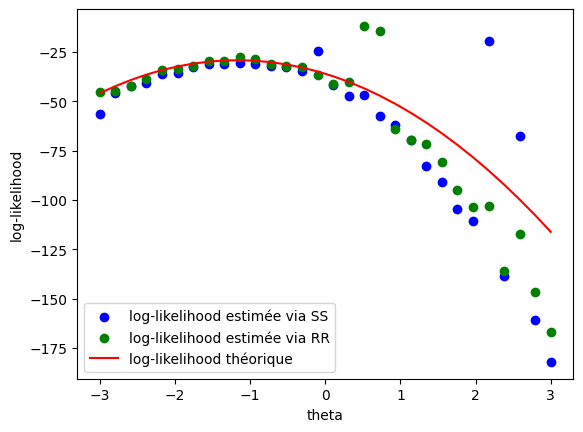

In [ ]:
gaussian_experience_full(debut = -3,fin = 3,n_sim = 500,n_interval = 30)

true value of theta 1.1929958189622867
25%
50%
75%


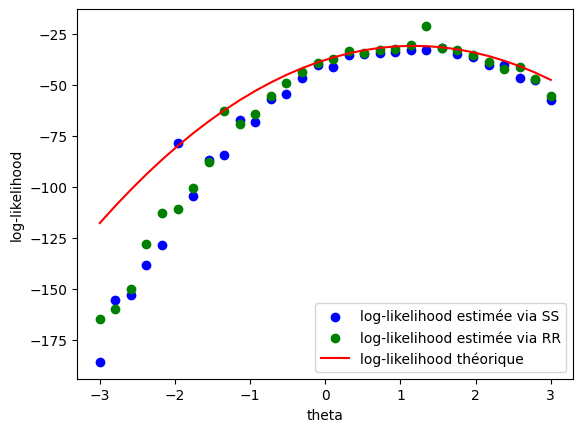

In [ ]:
gaussian_experience_full(debut = -3,fin = 3,n_sim = 500,n_interval = 30)

In [14]:
def estimate_both_SS_RR_without(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR

    for k in liste:
      
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    #theta_estimator = X[Y.index(max(Y))]

    
    return X, Y_SS,Y_RR

In [15]:
def gaussian_experience_biais(debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  #print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR_without(x,debut,fin,n_sim,n_interval)
  #print("theta estimé =",theta_estimator)
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]

  biais_median_RR = np.median([(Y_theorique[i]-Y_RR[i])**2 for i in range(len(Y_RR))])
  biais_median_SS = np.median([(Y_theorique[i]-Y_SS[i])**2 for i in range(len(Y_SS))])
  #biais_mean_RR = np.mean([(Y_theorique[i]-Y_RR[i])**2 for i in range(len(Y_RR))])
  #biais_mean_SS = np.mean([(Y_theorique[i]-Y_SS[i])**2 for i in range(len(Y_SS))])

  return biais_median_RR,biais_median_SS #biais_mean_RR,biais_mean_SS

In [16]:
def biais_plot(start,end,number):
  # we stay at n_interval = 50 fixed
  essais = np.linspace(start,end,number)
  biais_median_RR,biais_median_SS = [],[]
  #biais_mean_RR,biais_mean_SS = [],[]
  for n in essais:
    percentage = (n-start)/(end-start)*100
    print(percentage)
    biais_RR,biais_SS = gaussian_experience_biais(n_sim = int(n))
    biais_median_RR.append(biais_RR)
    biais_median_SS.append(biais_SS)
  plt.scatter(essais,biais_median_RR,color = 'green',label = "biais médian estimateur RR")
  plt.scatter(essais,biais_median_SS,color = 'blue',label = "biais médian estimateur SS")
  plt.xlabel('nombre de simulations par estimation de la log likelihood')
  plt.ylabel('biais des estimateurs de la log likelihood')
  plt.legend()
  plt.show()

0.0
25.0
50.0
75.0
100.0


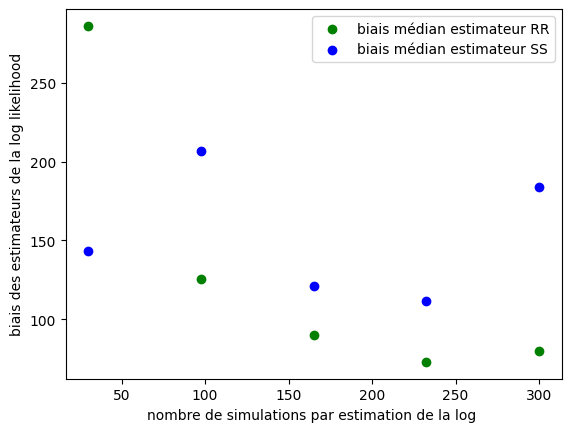

In [ ]:
biais_plot(30,300,5)

# **4) Fonction IWAE**

In [17]:
def estimator_IWAE(n_sim, x, K0, mean_vect, covar, A, b):

    IWAE = []

    for i in range(n_sim):

        # generate our data following our true parameter theta_true and our observations at mean_vect
        sum = 0

        z, z_O, z_E = generation_z(A,b,K0,covar,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K0,mean_vect,covar,x,z,z_O,z_E)

        w = [p[i]/q[i] for i in range(len(p))]  
        sum = np.log(np.mean(w))   
        IWAE.append(sum)
    
    mean_value = np.mean(IWAE)
    std_error_value = np.std(IWAE) / np.sqrt(len(IWAE))

    return mean_value #the mean value of the log likelihood 

In [18]:
def estimate_theta_IWAE(x, K0,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')
            c+=1
            
            Y.append(estimator_IWAE(n_sim,x, K0, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20)))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [19]:
def estimate_theta_IWAE_without(x, K0,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    # we cut our research interval of theta in n_interval parts to compute the loglikelihood on each one 

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y = [] #values of the log-likelihoods 

    for k in liste:
            Y.append(estimator_IWAE(n_sim,x, K0, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20)))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    theta_estimator = X[Y.index(max(Y))]

    
    return theta_estimator, X, Y

In [20]:
def gaussian_experience_IWAE(K0, debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  theta_estimator, X, Y = estimate_theta_IWAE(x, K0 ,debut,fin,n_sim,n_interval)
  #print("theta estimé =",theta_estimator)
  plt.scatter(X,Y,color = 'blue',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical og-likelihood')
  plt.legend()

  #biais_median = np.median([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  #biais_mean = np.mean([abs(Y_theorique[i]-Y[i]) for i in range(len(Y))])
  #print("le biais médian de la log likelihood vaut",biais_median )
  #print("le biais moyen de la log likelihood vaut",biais_mean )

true value of theta 1.5642696985570435
25%
50%
75%


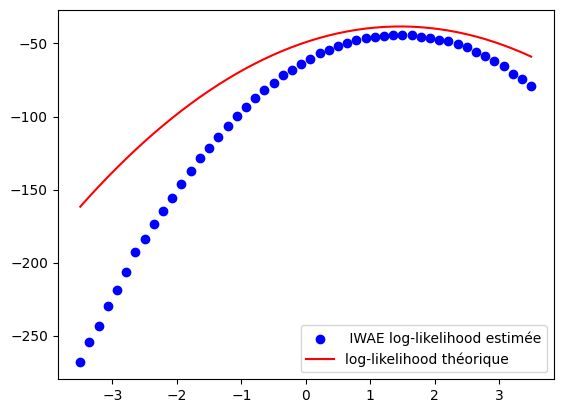

In [ ]:
gaussian_experience_IWAE(3)

true value of theta -0.09950117544717184
25%
50%
75%


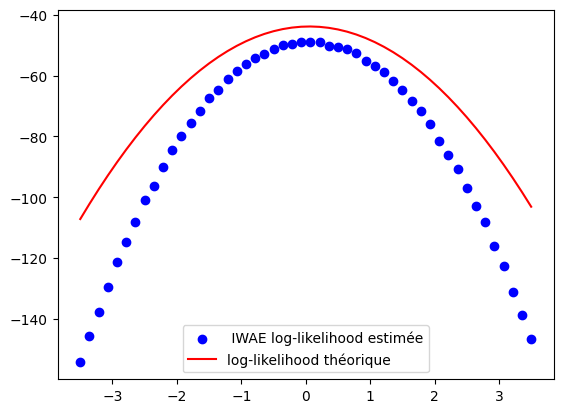

In [ ]:
gaussian_experience_IWAE(7)

# **5) Comparaison SS/RR/IWAE**

In [21]:
def gaussian_experience_full_2(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin,n_sim,n_interval)

  #print("theta estimé =",theta_estimator)
  #plt.figure(figsize=(8,6))
  plt.axis([debut-0.3,fin+0.3,min(min(Y_SS),min(Y_RR),min(Y_IWAE))-50, 100])
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimated with SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimated with RR')
  plt.scatter(X_IWAE,Y_IWAE,marker = 'x',linewidth = 2.5,color = 'y',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical log-likelihood')
  plt.axvline(x=theta_true, color='black', linestyle='--', label='theta_true='+ str('{:.3f}'.format(theta_true)))
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

  return Y_theorique, Y_SS, Y_RR, Y_IWAE

true value of theta -0.07923128565818358
25%
50%
75%
25%
50%
75%


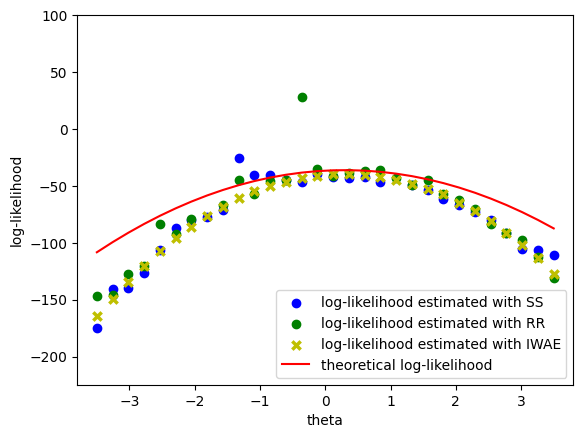

In [ ]:
gaussian_experience_full_2(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

true value of theta -0.28845476913398277
25%
50%
75%
25%
50%
75%


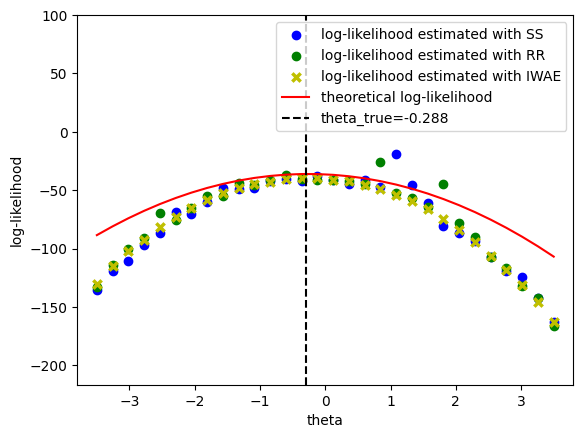

In [ ]:
Y_theorique, Y_SS, Y_RR, Y_IWAE = gaussian_experience_full_2(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

# **6) BIAIS**

In [22]:
def gaussian_experience_full_without(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):
  theta_true = np.random.normal(0,1)
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR = estimate_both_SS_RR_without(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE_without(x,K0,debut,fin,n_sim,n_interval)
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]

  return Y_theorique, Y_SS, Y_RR, Y_IWAE

In [23]:
def compute_bias(Y_theorique, Y_SS, Y_RR, Y_IWAE):
  bias_ss = np.median([(Y_theorique[i]-Y_SS[i])**2 for i in range(len(Y_SS))])
  bias_rr = np.median([(Y_theorique[i]-Y_RR[i])**2 for i in range(len(Y_RR))])
  bias_iwae = np.median([(Y_theorique[i]-Y_IWAE[i])**2 for i in range(len(Y_IWAE))])
  return bias_ss, bias_rr, bias_iwae

In [24]:
def plot_bias(K0, start,end,number):
  cost = np.linspace(start,end,number)
  bias_ss, bias_rr, bias_iwae = [],[],[]
  for e in cost:
    percentage = (e-start)/(end-start)*100
    print(percentage)
    Y_theorique, Y_SS, Y_RR, Y_IWAE = gaussian_experience_full_without(K0,debut = -3.5,fin = 3.5,n_sim = int(e),n_interval = 30)
    bias_ss_0, bias_rr_0, bias_iwae_0 = compute_bias(Y_theorique, Y_SS, Y_RR, Y_IWAE)
    bias_ss.append(bias_ss_0)
    bias_rr.append(bias_rr_0)
    bias_iwae.append(bias_iwae_0)
  plt.plot(cost,bias_ss, label = 'SS', c = 'blue')
  plt.plot(cost,bias_rr, label = 'RR', c = 'green')
  plt.plot(cost,bias_iwae, label = 'IWAE', c = 'y')
  plt.title('Bias squared of the log-likelihood')
  plt.xlabel('number of simulations per theta')
  plt.ylabel('mean bias squared of the log-likelihood')
  plt.legend()
  plt.show()

0.0
25.0
50.0
75.0
100.0


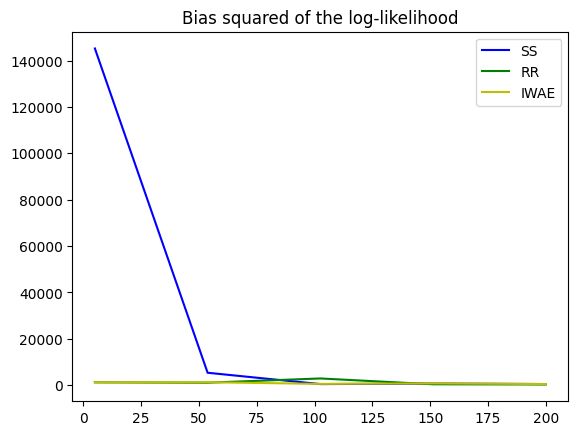

In [ ]:
plot_bias(4,5,200,5)

In [ ]:
plot_bias(3,5,100,7)

0.0
16.666666666666668
33.333333333333336
50.0


KeyboardInterrupt: ignored

# **6) FONCTION SUMO**

In [30]:
def delta_sumo(k, q, p):
    w_k2=[]
    w_k1=[]
    for i in range(k+1):
        w_k1.append(p[i]/q[i])
    for i in range(k+2):
        w_k2.append(p[i]/q[i])
    l_k1 = np.log(np.mean(w_k1))
    l_k2 = np.log(np.mean(w_k2))
    delta_sumo = l_k2-l_k1
    return delta_sumo

In [35]:
def sumo_estimator(n_sim, x, mean, cov, A, b, r):
    sumo = []
    for i in range(n_sim):
        sum_sumo = 0
        K = int(np.random.geometric(r))
        z, z_O, z_E = generation_z(A,b,K+2,cov,x)
        q, p, q_O, p_O, q_E, p_E = generation_q_p(A,b,K+2,mean,cov,x,z,z_O,z_E)
        w = np.log(p) - np.log(q)
            
        #third step : compute I0
        I0 = w.mean()
        
        for j in range(1,K):
            sum_sumo += (delta_sumo(j,q,p)/((1-r)**j))
            
        ml_ll_sumo = I0 + sum_sumo
        sumo.append(ml_ll_sumo)
        
    mean_value = np.mean(sumo)
    #std_error_value = np.std(sumo) / np.sqrt(len(sumo))

    return mean_value

In [32]:
def estimate_both_SS_RR_SUMO(x,debut = -4,fin = 4,n_sim = 100,n_interval = 50):

    liste = np.linspace(debut,fin,n_interval)
    X = [] #values of theta where we compute the log-likelihood
    Y_SS = [] #values of the log-likelihoods SS
    Y_RR = [] #values of the log-likelihoods RR
    Y_SUMO = []

    c = 0 
    for k in liste:

            if c == n_interval//4:
              print('25%')
            elif c == n_interval//2:
              print('50%')
            elif c == (3*n_interval)//4:
              print('75%')

            c+=1
            Y_SS.append(estimator_ML_SS(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_RR.append(estimator_ML_RR(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            Y_SUMO.append(sumo_estimator(n_sim,x, np.zeros(20)+k , np.identity(20), np.identity(20), np.zeros(20), 0.6))
            X.append(k)

    # we find the maximiser of the log-likelihood and we take it as our estimator of theta
    #theta_estimator = X[Y.index(max(Y))]

    
    return X, Y_SS,Y_RR,Y_SUMO

In [47]:
def gaussian_experience_full_3(K0,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 50):

  # we randomly choose the true parameter theta 
  theta_true = np.random.normal(0,1)
  print("true value of theta",theta_true)
  #theta_true = np.random.multivariate_normal(np.zeros(20),np.identity(20))
  #print("true value of theta",theta_true)

  # we generate our data following this true theta
  x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))
  X,Y_SS,Y_RR,Y_SUMO = estimate_both_SS_RR_SUMO(x,debut,fin,n_sim,n_interval)
  esti,X_IWAE, Y_IWAE = estimate_theta_IWAE(x,K0,debut,fin,n_sim,n_interval)

  #print("theta estimé =",theta_estimator)
  #plt.figure(figsize=(8,6))
  plt.axis([debut-0.3,fin+0.3,min(min(Y_SS),min(Y_RR),min(Y_IWAE))-50, 75])
  plt.scatter(X,Y_SS,color = 'blue',label = 'log-likelihood estimated with SS')
  plt.scatter(X,Y_RR,color = 'green',label = 'log-likelihood estimated with RR')
  plt.scatter(X,Y_SUMO,marker = 'x',linewidth = 2.5,color = 'm', label = 'log-likelihood estimated with SUMO')
  plt.scatter(X_IWAE,Y_IWAE,marker = 'x',linewidth = 2.5,color = 'y',label = 'log-likelihood estimated with IWAE')
  Y_theorique = [np.log(calcul_likelihood(x,i)) for i in X]
  plt.plot(X,Y_theorique, color = 'red',label = 'theoretical log-likelihood')
  plt.axvline(x=theta_true, color='black', linestyle='--', label='theta_true='+ str('{:.3f}'.format(theta_true)))
  plt.xlabel('theta')
  plt.ylabel('log-likelihood')
  plt.legend()

  return Y_theorique, Y_SS, Y_RR,Y_SUMO,Y_IWAE

true value of theta -0.19623833068787722
25%
50%
75%
25%
50%
75%


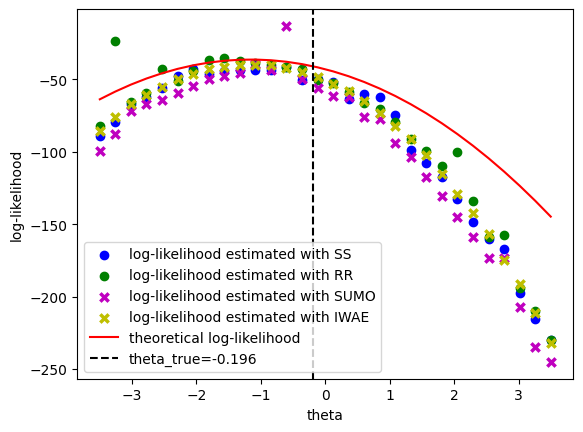

In [42]:
Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE = gaussian_experience_full_3(4,debut = -3.5,fin = 3.5,n_sim = 100,n_interval = 30)

true value of theta 0.8453469417555549
25%
50%
75%
25%
50%
75%


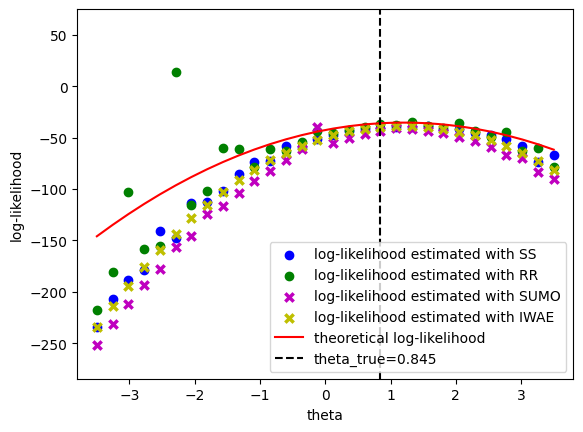

In [53]:
Y_theorique, Y_SS, Y_RR,Y_SUMO, Y_IWAE = gaussian_experience_full_3(4,debut = -3.5,fin = 3.5,n_sim = 500,n_interval = 30)

# **5) GRADIENT** 

In [ ]:
import math

In [ ]:
def gradient_theo(x,theta):
  return 0.5*(np.array(x)-theta)

In [ ]:
theta_true = np.random.normal(0,1)
print(theta_true)
x = np.random.multivariate_normal(np.zeros(20)+theta_true, 2*np.identity(20))

0.0928791831712521


In [ ]:
theta_estimator_test, X_test, Y_test =  estimate_theta(x,debut = -3.5,fin = 3.5,n_sim = 300,n_interval = 50)


25%
50%
75%


In [ ]:
np.gradient(Y_test)

array([ 8.08792718e+00,  1.83580116e+01,  3.36792057e+01,  5.38424308e+00,
       -1.24512481e+01,  6.06545605e+00,  1.13499481e+01,  5.85980660e+00,
        1.64078196e+01,  1.11936637e+01,  9.23838536e+00,  3.50734616e+00,
       -6.93149973e+00,  6.30557431e+00,  2.89594188e+01,  3.99164626e+00,
        4.69985628e+01,  6.49925434e+00, -6.44008606e+01,  2.42932221e+00,
        2.63662374e+00,  1.58290553e+00,  2.07338341e+00,  1.50085387e+00,
        7.03920256e+00,  1.31308698e+00, -3.52172373e+00,  6.94281536e-01,
        6.51218725e-01,  2.79244862e+00, -1.57360535e+00, -3.40733479e+00,
        2.42339645e-01, -5.85845264e-01, -2.84060594e+00, -2.57724442e+00,
       -5.13370764e-02, -2.74344956e+00, -5.20311145e+00, -4.67724889e+00,
       -3.25881261e+00, -2.46084807e+00, -4.18104661e+00, -6.05453611e+00,
       -6.57402509e+00, -4.07605057e+00,  3.87318815e+00,  1.52533782e+01,
       -1.47131856e+01, -4.93130461e+01])

In [ ]:
#cleaned_y_test = [x for x in Y_test if (math.isnan(x)!=False)]
#cleaned_x_test = [X_test[i] for i in range(len(X_test)) if (math.isnan(Y_test[i])!=False)]
grad_test = np.gradient(Y_test)


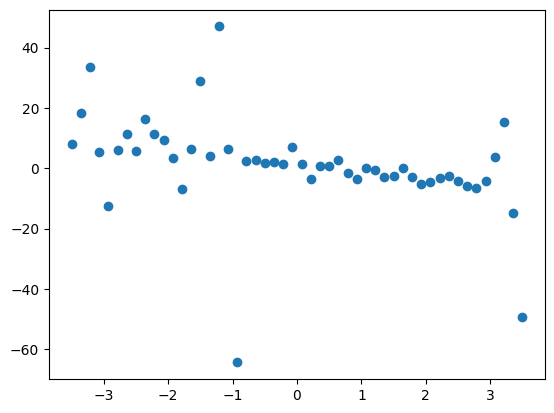

In [ ]:
plt.scatter(X_test,grad_test)
#plt.plot(X_test,[gradient_theo])